In [1]:
%matplotlib  inline

### Speckle Noise Reduction Method Based on Fuzzy Approach for Synthetic Aperture Radar Images 

https://pdfs.semanticscholar.org/8439/730f3520c7a9614e46716c0b76ee205abca1.pdf

## Preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import misc, signal

import imageio

import pywt

Text(0.5, 1.0, 'Blurred pict')

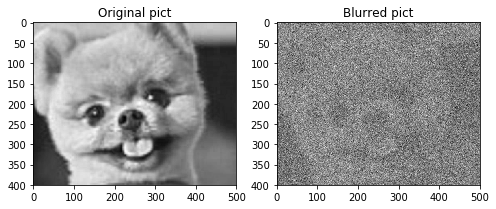

In [141]:
pict = imageio.imread('lab - 8\test.jpg')
pict = pict[400:800, 1300:1800, 0]
blurred_1 = pict + np.random.normal(loc=0, scale=200, size=pict.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(pict, cmap='gray')
ax[0].set_title('Original pict')
ax[1].imshow(blurred_1, cmap='gray')
ax[1].set_title('Blurred pict')

Text(0.5, 1.0, 'Blurred pict')

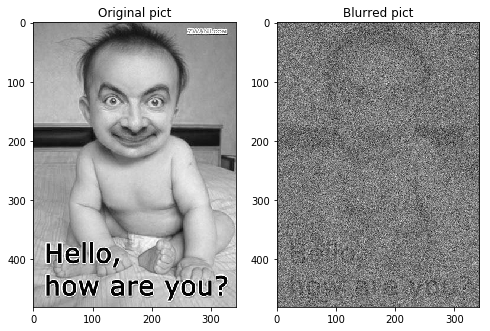

In [142]:
pict = imageio.imread('test1.jpg')
pict = pict[:, :, 0]
blurred_2 = pict + np.random.normal(loc=0, scale=200, size=pict.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(pict, cmap='gray')
ax[0].set_title('Original pict')
ax[1].imshow(blurred, cmap='gray')
ax[1].set_title('Blurred pict')

## Fuzzy filters (ATMAV, ATMED)
* ATMED - Asymmetrical Triangular Median Filter.
* ATMAV - Asymmetrical Triangular Moving Average Filter

In [47]:
def ATMED(value, v_min, v_median, v_max):
    
    if v_min <= value <= v_median:
        return 1 - (v_median - value) / (v_median - v_min)
    
    if v_median <= value <= v_max:
        return 1 - (value - v_median) / (v_max - v_median)
    
    if v_min == v_median or v_median == v_max:
        return 1

In [48]:
def ATMAV(value, v_min, v_mean, v_max):
    
    if v_min <= value <= v_mean:
        return 1 - (v_mean - value) / (v_mean - v_min)
    
    if v_mean <= value <= v_max:
        return 1 - (value - v_mean) / (v_max - v_mean)
    
    if v_min == v_mean or v_mean == v_max:
        return 1

In [49]:
def construct_filter(sub_matrix, filter_name='ATMAV'):
    
    row = sub_matrix.ravel().astype(np.float64)
    
    v_min = np.min(row)
    v_max = np.max(row)
    
    v_median = np.median(row)
    v_mean = np.mean(row)

    func = None
    
    if filter_name == 'ATMAV':
        v_m = v_mean
        func = ATMAV
    if filter_name == 'ATMED':
        v_m = v_median
        func = ATMED
        
    FILTER = np.zeros(sub_matrix.shape)
    
    h, w = FILTER.shape
    
    for i in range(h):
        for j in range(w):
            value = sub_matrix[i, j]
            FILTER[i, j] = func(value, v_min, v_m, v_max)
            
    return FILTER

In [41]:
def fuzzy_filter(img, window_size=12, method='ATMAV'):

    h, w = img.shape
    
    output = np.zeros(img.shape)
    
    output[0, :] = img[0, :]
    output[:, 0] = img[:, 0]
    output[-1, :] = img[-1, :]
    output[:, -1] = img[:, -1]
    
    for i in range(window_size, h - window_size - 1):
        for j in range(window_size, w - window_size - 1):
            sub_img = img[i - window_size: i + window_size + 1, j - window_size: j + window_size + 1]
            FILTER = construct_filter(sub_matrix=sub_img, filter_name=method)
            
            output[i, j] = (sub_img * FILTER).ravel().sum()
            
    return output

# Comparison of there filters

# Results

In [148]:
def util(blurred):
    coeffs = pywt.dwt2(blurred, 'haar')
    cA, (cH, cV, cD) = coeffs
    cA = fuzzy_filter(cA, method='ATMAV', window_size=1)
    cH = np.clip(cH, -10, 10)
    cV = np.clip(cV, -10, 10)
    cD = np.clip(cD, -10, 10)
    r = np.zeros(cD.shape)
    atmav_recovered = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    
    coeffs = pywt.dwt2(blurred, 'haar')
    cA, (cH, cV, cD) = coeffs
    cA = fuzzy_filter(cA, method='ATMED', window_size=1)
    cH = np.clip(cH, -10, 10)
    cV = np.clip(cV, -10, 10)
    cD = np.clip(cD, -10, 10)
    r = np.zeros(cD.shape)
    atmed_recovered = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    
    wiener_recovered = scipy.signal.wiener(np.array(blurred))
    
    return atmed_recovered, atmav_recovered, wiener_recovered

In [149]:
def plot_results(blurred, atmav_recovered, atmed_recovered, wiener_recovered):
    plt.figure(figsize=(10, 8))

    plt.subplot(221)
    plt.title('Изначально зашумленное изображение')
    plt.imshow(blurred, cmap='gray')

    plt.subplot(222)
    plt.title('Fuzzy ATMAV')
    plt.imshow(atmav_recovered, cmap='gray')

    plt.subplot(223)
    plt.title('Fuzzy ATMED')
    plt.imshow(atmed_recovered, cmap='gray')

    plt.subplot(224)
    plt.title('Wiener filter')
    plt.imshow(wiener_recovered, cmap='gray')

    plt.show()

## 1-st comparison

CPU times: user 6.25 s, sys: 72 µs, total: 6.25 s
Wall time: 6.25 s


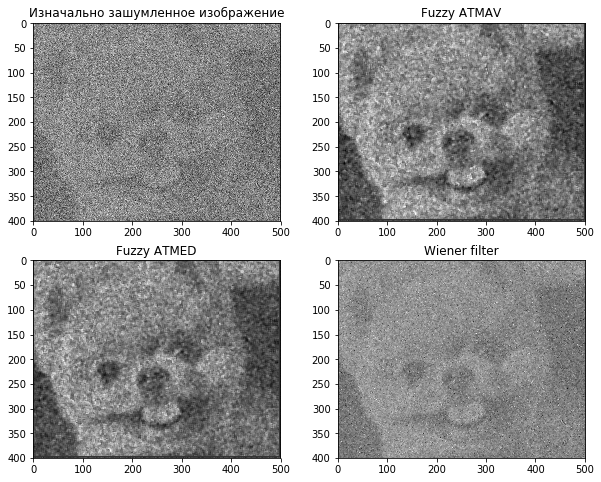

In [146]:
%time atmed_recovered, atmav_recovered, wiener_recovered = util(blurred_1)
plot_results(blurred_1, atmed_recovered, atmav_recovered, wiener_recovered)

## 2-nd comparison

CPU times: user 4.89 s, sys: 4.11 ms, total: 4.89 s
Wall time: 4.89 s


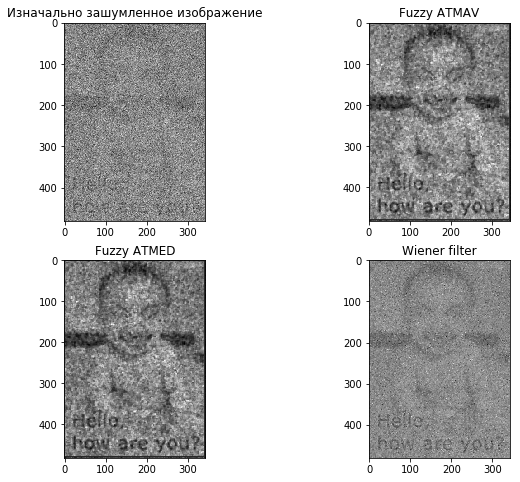

In [147]:
%time atmed_recovered, atmav_recovered, wiener_recovered = util(blurred_2)
plot_results(blurred_2, atmed_recovered, atmav_recovered, wiener_recovered)